# Occupazione della stanza

Per prima cosa iniziamo a recuperare il dataset

In [46]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

X = pd.read_csv('./data/datatraining.txt')

Definiamo tre palette: una con i colori saturi, una con i colori desaturati e una con i colori scuri

In [47]:
palette_saturated = [
    '#e41a1c',  # rosso
    '#377eb8',  # blu
    '#4daf4a',  # verde
    '#984ea3',  # viola
    '#ff7f00',  # arancio
    '#ffff33',  # giallo
    '#a65628'   # marrone
]

# Palette 2: colori non saturi / pastellati (soft, meno contrasto cromatico ma distinti per tonalità)
palette_pastel = [
    '#fbb4ae',  # rosa chiaro
    '#b3cde3',  # azzurro chiaro
    '#ccebc5',  # verde chiaro
    '#decbe4',  # lilla chiaro
    '#fed9a6',  # pesca chiaro
    '#ffffcc',  # giallo pallido
    '#e5d8bd'   # beige chiaro
]

# Palette 3: colori scuri (contrasto per background chiaro, buoni per elementi pesanti)
palette_dark = [
    '#08306b',  # blu scuro
    '#00441b',  # verde scuro
    '#67000d',  # rosso scuro
    '#4a1486',  # viola scuro
    '#8c2d04',  # arancio scuro / marrone
    '#253494',  # indaco scuro
    '#2b2b2b'   # grigio scuro
]

Quindi andiamo a creare una nuova feature che indica il giorno della settimana (facciamo un mapping con i nomi dei giorni in italiano)

In [48]:
X['date'] = pd.to_datetime(X['date'], format='mixed')
X['weekday'] = X['date'].dt.day_name()
mapping = {
    'Monday':'Lunedì','Tuesday':'Martedì','Wednesday':'Mercoledì',
    'Thursday':'Giovedì','Friday':'Venerdì','Saturday':'Sabato','Sunday':'Domenica'
}
order = ['Lunedì','Martedì','Mercoledì','Giovedì','Venerdì','Sabato','Domenica']
X['weekday'] = X['weekday'].map(mapping)

Visualizziamo il numero di presenze per ogni giorno della settimana

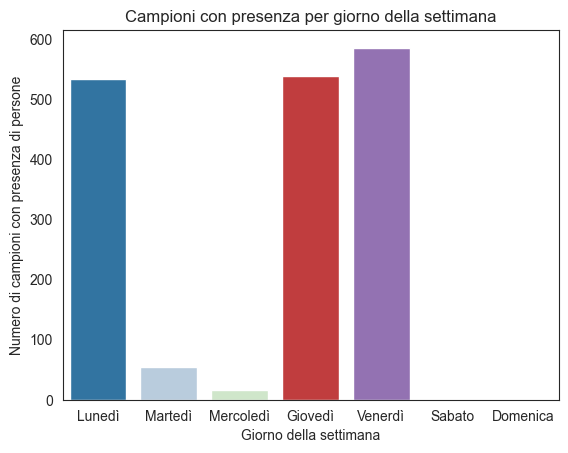

In [55]:
counts = X.groupby('weekday')['Occupancy'].sum()


highlight_days = ['Lunedì','Giovedì', 'Venerdì']

colors_map = {
    day: (palette_saturated[i] if day in highlight_days else palette_pastel[i])
    for i, day in enumerate(order)
}

sns.barplot(x=counts.index, y=counts.values, order=order, hue=counts.index, palette=colors_map)
plt.xlabel('Giorno della settimana')
plt.ylabel('Numero di campioni con presenza di persone')
plt.title('Campioni con presenza per giorno della settimana')
plt.show()

Notiamo dal barchart che si ha una particolare presenza il lunedì, il giovedì e il venerdì, mentre il sabato e la domenica non c'è mai nessuno nella stanza.


Ora proviamo a visualizzare, utilizzando degli small multiples, l'andamento temporale di ogni feature, rispetto al fatto che ci sia o meno qualcuno nella stanza (evidenziando in rosso quando qualcuno è presente nella stanza) e dividendo i giorni con delle barre verticali.

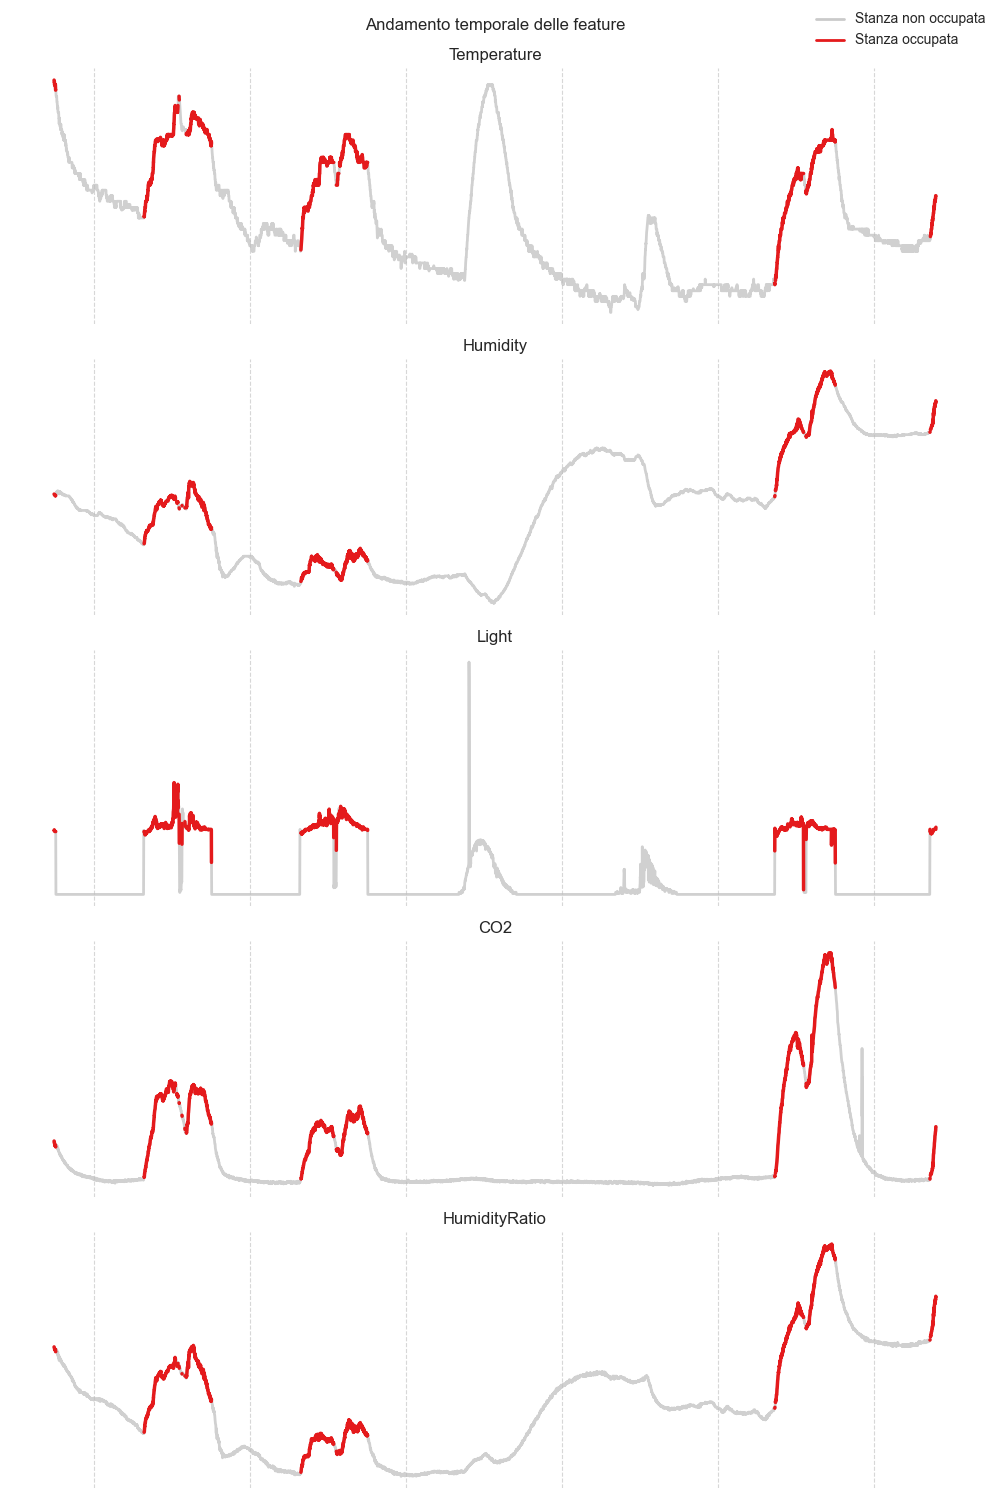

In [50]:
# stile minimale
sns.set_style('white')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# configurazione colori
grey = '#bdbdbd'
red = '#e41a1c'

# seleziona feature numeriche (escludi date, weekday, Occupancy)
features = [c for c in X.columns if c not in ['date', 'weekday', 'Occupancy']]

# layout dei subplot
n = len(features)
columns = 1
rows = math.ceil(n / columns)
fig, axes = plt.subplots(rows, columns, figsize=(10 * columns, 3 * rows), squeeze=False)
axes = axes.ravel()

for ax, feat in zip(axes, features):
    sub = X[['date', 'Occupancy', feat]].sort_values('date').dropna(subset=['date', feat])

    # disegna la serie completa in grigio
    ax.plot(sub['date'], sub[feat], color=grey, alpha=0.7, linewidth=2)

    # trova blocchi continui dove Occupancy == 1 e disegna solo quei segmenti in rosso
    mask = sub['Occupancy'] == 1
    # ogni volta che mask cambia, si crea un nuovo gruppo
    groups = mask.ne(mask.shift(fill_value=False)).cumsum()
    for _, grp in sub.groupby(groups):
        if grp['Occupancy'].iloc[0] == 1:
            ax.plot(grp['date'], grp[feat], color=red, alpha=1.0, linewidth=2.5)

    # linee verticali a mezzanotte
    days = pd.to_datetime(sub['date'].dt.normalize().unique())
    y_min, y_max = ax.get_ylim()
    for day in days:
            t = day
            if sub['date'].iloc[0] <= t <= sub['date'].iloc[-1]:
                ax.axvline(t, color=grey, linestyle='--', linewidth=0.8, alpha=0.6)

    ax.set_title(feat)
    # rimuovi bordi e tacche per uno stile minimale
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

# legenda senza bordo
handle0 = mlines.Line2D([], [], color=grey, label='Stanza non occupata', linewidth=2, alpha=0.8)
handle1 = mlines.Line2D([], [], color=red, label='Stanza occupata', linewidth=2)
fig.legend(handles=[handle0, handle1], loc='upper right', frameon=False)
fig.suptitle('Andamento temporale delle feature', y=0.99)
plt.tight_layout()
plt.show()